# Tahu lah apa ini?

In [43]:
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, VotingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from pyod.models.hbos import HBOS
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, OutlierMixin
from scipy.spatial.distance import mahalanobis

In [45]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/agriculture_dataset.csv'
# file_path = '01.Dataset-Rofiqul/Ujicoba3-29052024/agriculture_dataset.csv'
# file_path = 'dataset/agriculture_dataset.csv'
# file_path = 'dataset/09_05_1_AgricultureOutliersResult_30052024.csv'
# file_path = 'dataset/09_05_3_0_AgricultureOutliersDetectionResults.csv'
file_path = 'dataset/09_05_3_2_AgricultureOutliersVotingBasedResult.csv'
data= pd.read_csv(file_path)




In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
hard=data[data['majority_voting']==1]
soft=data[data['average_voting']==1]

In [48]:
# Count the number of outliers and non-outliers for each voting method
hard_outlier_count = hard[hard['majority_voting'] == -1].shape[0]
hard_non_outlier_count = hard[hard['majority_voting'] == 1].shape[0]

soft_outlier_count = soft[soft['average_voting'] == -1].shape[0]
soft_non_outlier_count = soft[soft['average_voting'] == 1].shape[0]
print(f"Hard Voting - Number of outliers: {hard_outlier_count}")
print(f"Hard Voting - Number of non-outliers: {hard_non_outlier_count}")

print(f"Soft Voting - Number of outliers: {soft_outlier_count}")
print(f"Soft Voting - Number of non-outliers: {soft_non_outlier_count}")

Hard Voting - Number of outliers: 0
Hard Voting - Number of non-outliers: 2101
Soft Voting - Number of outliers: 0
Soft Voting - Number of non-outliers: 2101


In [49]:
# Summary of outliers detection
outlier_summary = {
    'Method': ['Isolation Forest', 'DBSCAN', 'One-Class SVM'],
    'Outliers': [
        np.sum(hard['if_outlier'] == -1),
        np.sum(hard['dbscan_outlier'] == -1),
        np.sum(hard['ocsvm_outlier'] == -1),
    ],
    'Inliers': [
        np.sum(hard['if_outlier'] == 1),
        np.sum(hard['dbscan_outlier'] == 1),
        np.sum(hard['ocsvm_outlier'] == 1),
    ]
}
summary_df = pd.DataFrame(outlier_summary)
summary_df

,Method,Outliers,Inliers
0,Isolation Forest,80,2021
1,DBSCAN,0,2101
2,One-Class SVM,87,2014


## Prepare Train Test Split

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# Preprocess the data
features = hard.drop(columns=['N2O'])  # Assuming 'N2O' is the target column
target = hard['N2O']

# Encode categorical variables if any
label_encoders = {}
for column in features.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    features[column] = label_encoders[column].fit_transform(features[column])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Define X and y
X = scaled_features
y = target

In [52]:
def train_and_evaluate(test_size):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test Size: {test_size}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual N2O')
    plt.ylabel('Predicted N2O')
    plt.title(f'Actual vs Predicted N2O (Test Size: {test_size})')
    plt.savefig('visual/0906_1_ActualVsPredictedN2O_test_'+(str(int(test_size*100)))+'_NoOutlier.png')

    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Residuals Distribution (Test Size: {test_size})')
    plt.savefig('visual/0906_2_ResidualDistribution_test_'+(str(int(test_size*100)))+'_NoOutlier.png')

    plt.show()

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(model, max_num_features=10)
    plt.savefig('visual/0906_3_FeatureImportance_test_'+(str(int(test_size*100)))+'_NoOutlier.png')
    plt.title('Feature Importance')
    plt.show()

    return model, mse, rmse, mae, r2

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.2
Mean Squared Error: 3.954817984615661
Root Mean Squared Error: 1.98867241762329
Mean Absolute Error: 1.436238124181852
R-squared: 0.7690238224966232


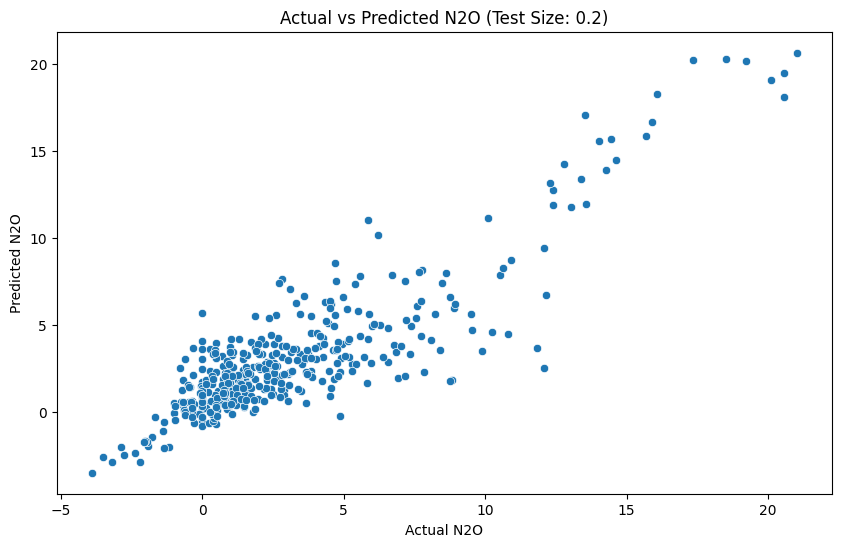

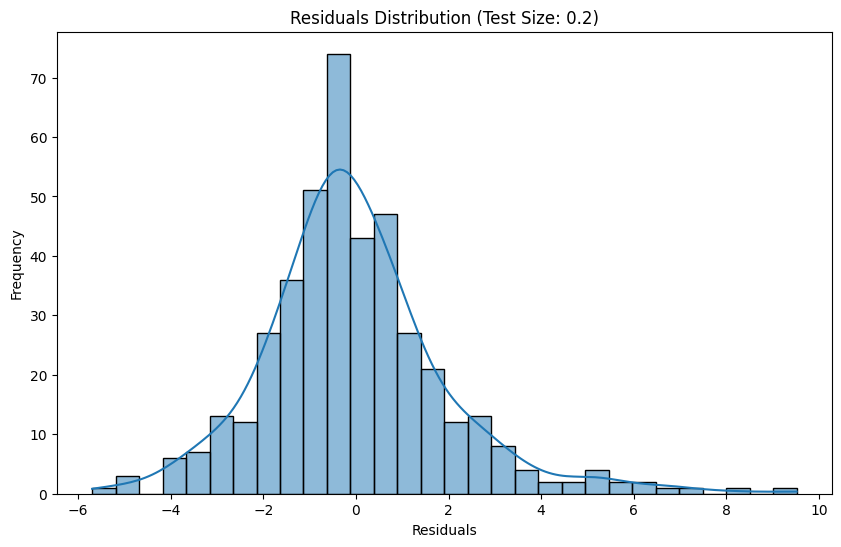

<Figure size 1000x600 with 0 Axes>

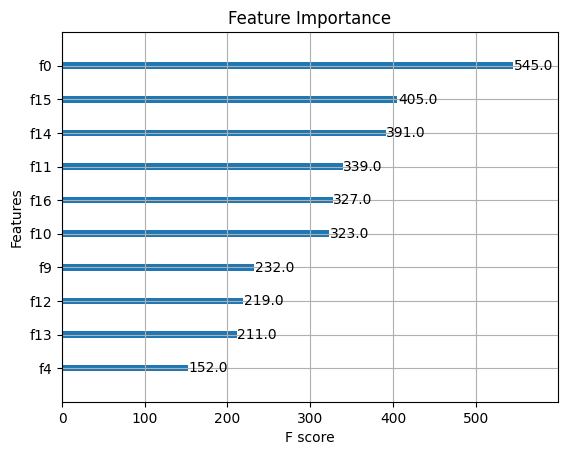

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.25
Mean Squared Error: 4.469760252167541
Root Mean Squared Error: 2.11418075200952
Mean Absolute Error: 1.5245621796005957
R-squared: 0.740618412671332


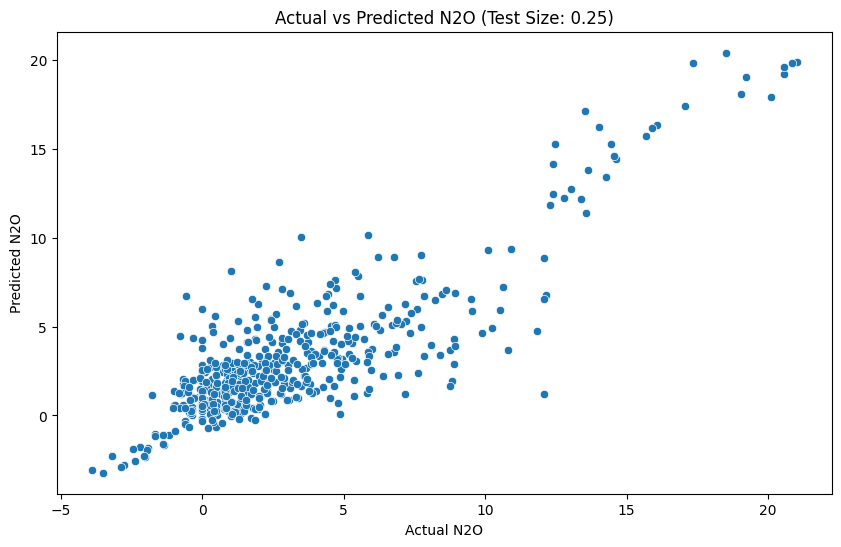

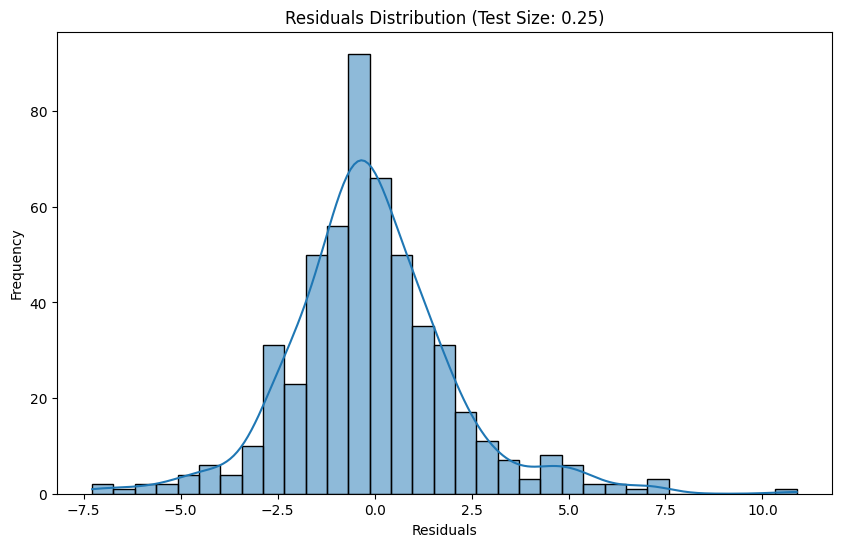

<Figure size 1000x600 with 0 Axes>

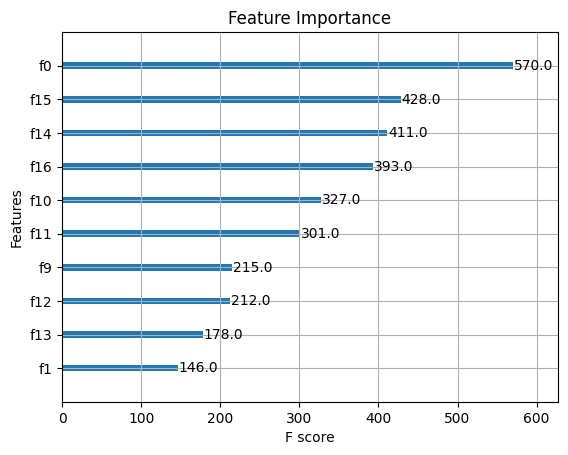

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.3
Mean Squared Error: 4.262136393958576
Root Mean Squared Error: 2.064494222311745
Mean Absolute Error: 1.4878054080406296
R-squared: 0.7435392983181861


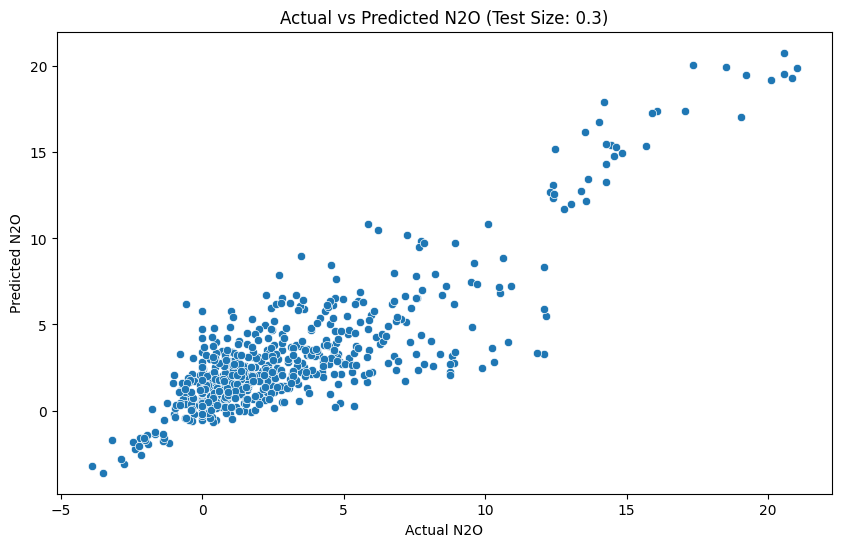

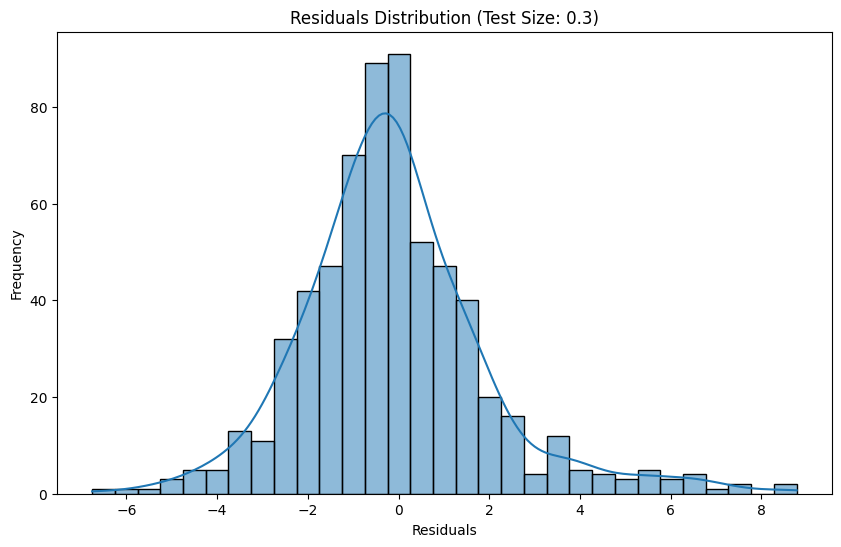

<Figure size 1000x600 with 0 Axes>

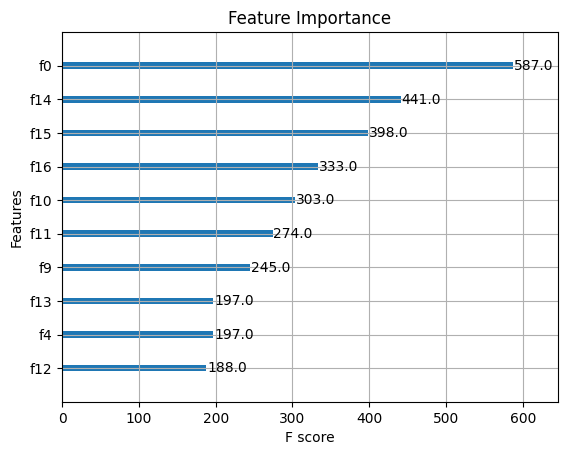

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.35
Mean Squared Error: 4.292691099464643
Root Mean Squared Error: 2.0718810534064556
Mean Absolute Error: 1.510983545989673
R-squared: 0.7423103587524713


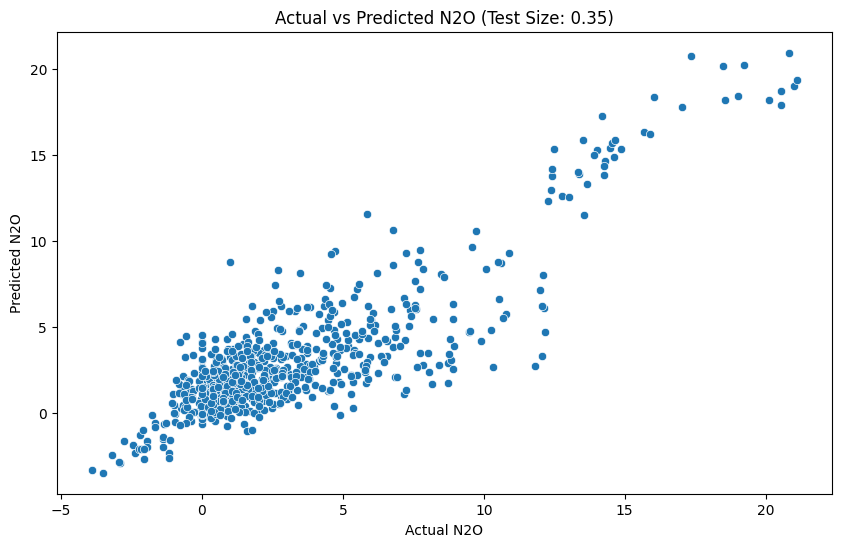

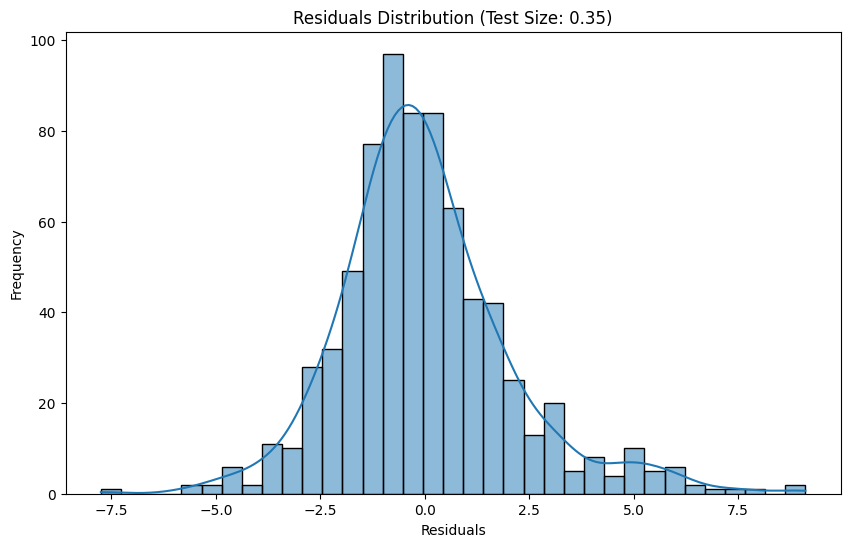

<Figure size 1000x600 with 0 Axes>

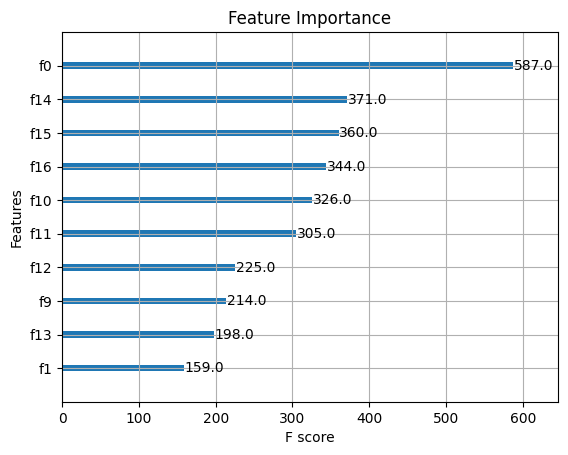

In [53]:
test_sizes = [0.2,0.25, 0.3, 0.35]
results = {}
# Initialize an empty list to store results
evaluation = []
for test_size in test_sizes:
    model, mse, rmse, mae, r2 = train_and_evaluate(test_size)
    results[test_size] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}
    evaluation.append({
        'test_size': test_size,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })


In [54]:
# Convert results to a DataFrame
eval_df = pd.DataFrame(evaluation)

# Save the results to a CSV file
eval_df.to_csv('dataset/0906_1_xgboost_evaluation_datauji_plain_nooutliers_results.csv', index=False)
eval_df

,test_size,mse,rmse,mae,r2
0,0.20,3.954818,1.988672,1.436238,0.769024
1,0.25,4.469760,2.114181,1.524562,0.740618
2,0.30,4.262136,2.064494,1.487805,0.743539
3,0.35,4.292691,2.071881,1.510984,0.742310
